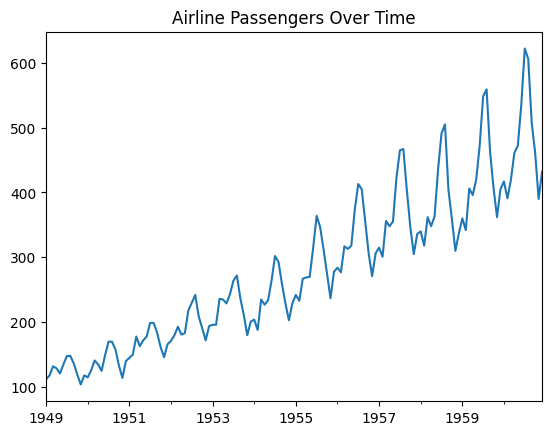

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641
ADF Statistic after Seasonal Differencing: -15.595618083746334
p-value: 1.8565116001234705e-28


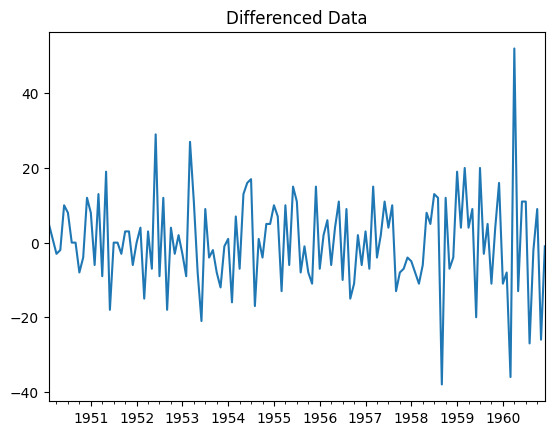

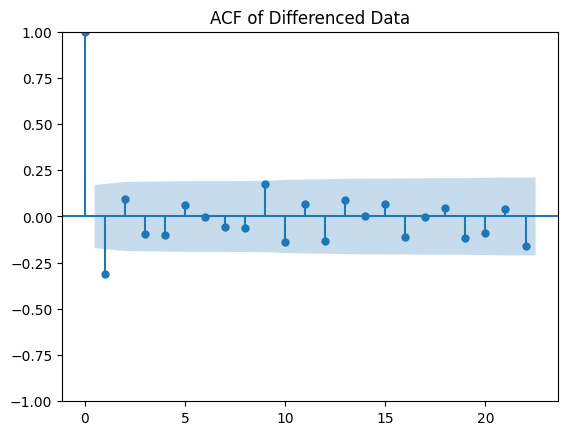

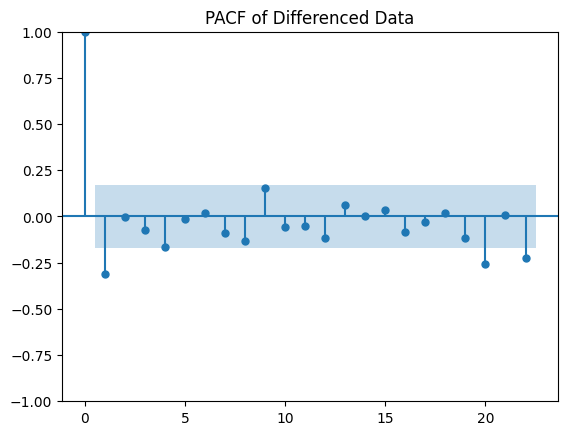

In [3]:
# Ignore warnings for cleaner output
from warnings import filterwarnings
filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.datasets import get_rdataset
import matplotlib.pyplot as plt

# Load the AirPassengers dataset
# This dataset contains monthly passenger numbers for an airline
data = get_rdataset("AirPassengers").data
df = pd.Series(data['value'].values, index=pd.date_range(start='1949-01', periods=len(data['value']), freq='M'))
df.index = pd.DatetimeIndex(df.index).to_period('M')  # Convert to monthly periods

# Plot the original time series
df.plot()
plt.title('Airline Passengers Over Time')
plt.show()

# Step 1: Check for stationarity using Augmented Dickey-Fuller (ADF) Test
result = adfuller(df)
print('ADF Statistic:', result[0])
print('p-value:', result[1])  # A p-value > 0.05 indicates non-stationarity

# Step 2: Apply seasonal differencing (lag 12) to handle seasonality
if result[1] > 0.05:  # If non-stationary
    df_diff = df.diff(12).dropna()  # Seasonal differencing
    df_diff = df_diff.diff().dropna()
    result = adfuller(df_diff)
    print('ADF Statistic after Seasonal Differencing:', result[0])
    print('p-value:', result[1])

    # # If still non-stationary, apply first-order differencing
    # if result[1] > 0.05:
    #     df_diff = df_diff.diff().dropna()  # First-order differencing
    #     result = adfuller(df_diff)
    #     print('ADF Statistic after Seasonal Differencing and differencing:', result[0])
    #     print('p-value:', result[1])
#     else:
#       print("No differencing done")
# print("----------------------")

# Plot the differenced data
df_diff.plot()
plt.title('Differenced Data')
plt.show()

# Step 3: Analyze ACF and PACF plots to identify p, d, q values
plot_acf(df_diff)
plt.title('ACF of Differenced Data')
plt.show()

plot_pacf(df_diff)
plt.title('PACF of Differenced Data')
plt.show()


Best BIC: 1029.5890844361481
Best order: (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -507.493
Date:                Thu, 21 Nov 2024   AIC                           1020.986
Time:                        11:37:25   BIC                           1029.589
Sample:                    02-28-1950   HQIC                          1024.482
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3026      0.078     -3.879      0.000      -0.455      -0.150
ma.L1         -0.9994      1.317     -0.759      0.448      -3.580       1.582
s

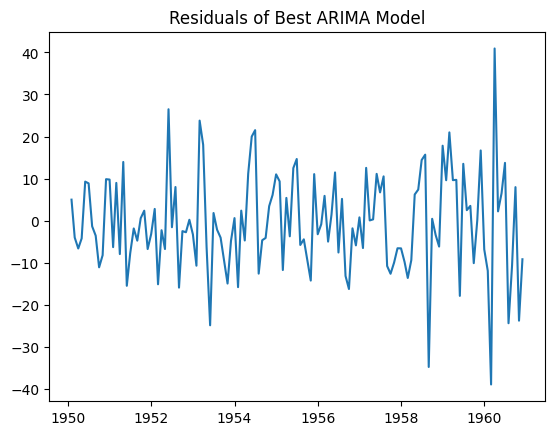

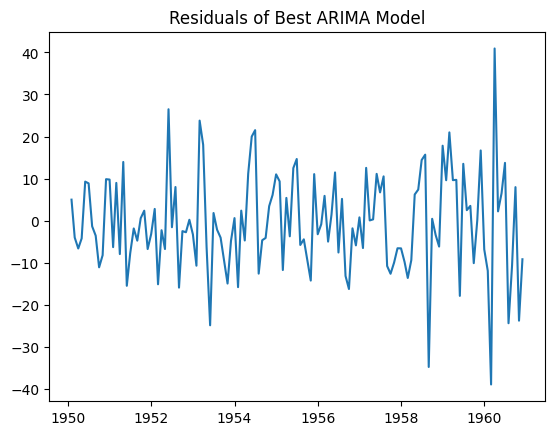

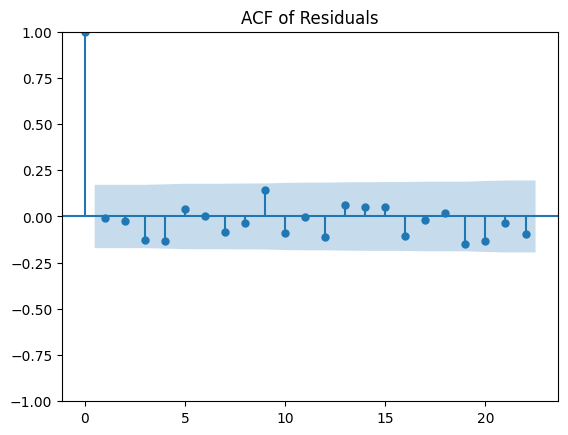

Forecasted Values:
1961-01    0.532200
1961-02    0.068612
1961-03    0.208877
1961-04    0.166438
1961-05    0.179279
1961-06    0.175393
1961-07    0.176569
1961-08    0.176213
1961-09    0.176321
1961-10    0.176288
1961-11    0.176298
1961-12    0.176295
Freq: M, Name: predicted_mean, dtype: float64


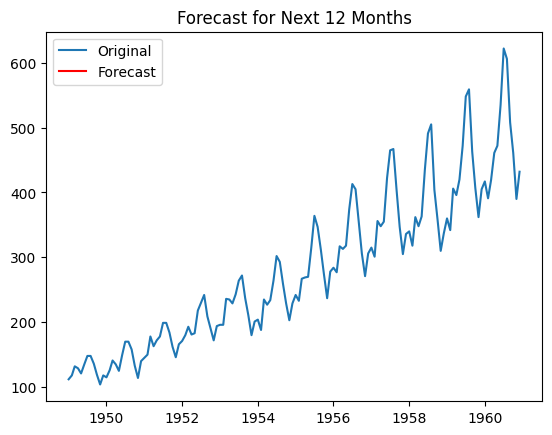

In [4]:
# Ignore warnings for cleaner output
from warnings import filterwarnings
filterwarnings('ignore')

# Step 4: Fit an initial ARIMA model based on guessed p, d, q
p, d, q = 2, 0, 2  # Initial guesses based on ACF and PACF plots
# d =0 since we already did differencing twice
model = ARIMA(df_diff, order=(p, d, q))
model_fit = model.fit()

# Step 5: Perform hyperparameter search for the best (p, d, q) based on BIC
best_bic = np.inf
best_order = None

# Define search ranges for p, d, q
p_range = range(0, 6)
d_range = range(0, 2)
q_range = range(0, 6)

# Iterate through all combinations of p, d, q
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # Fit the ARIMA model
                model = ARIMA(df_diff, order=(p, d, q))
                model_fit = model.fit()
                bic = model_fit.bic

                # Check if this is the best model so far
                if bic < best_bic:
                    best_bic = bic
                    best_order = (p, d, q)
                    best_model = model_fit
            except Exception as e:
                continue

# Print the best model's BIC and order
print(f"Best BIC: {best_bic}")
print(f"Best order: {best_order}")

# Step 6: Print model summary and analyze residuals
print(best_model.summary())

# Plot residuals to check for randomness
residuals = pd.DataFrame(best_model.resid)
residuals.index = residuals.index.to_timestamp()  # Convert PeriodIndex to DatetimeIndex

# Plot the residuals
plt.figure()
plt.plot(residuals.index, residuals[0])  # Use index and residual values explicitly
plt.title('Residuals of Best ARIMA Model')
plt.show()

plt.figure()
plt.plot(residuals)
plt.title('Residuals of Best ARIMA Model')
plt.show()

# Step 7: Plot ACF of residuals to confirm white noise
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

# Step 8: Forecast future values
forecast = best_model.forecast(steps=12)  # Forecast the next 12 periods
print('Forecasted Values:')
print(forecast)

# Plot the forecasted values
forecast_index = pd.date_range(start=df.index[-1].start_time, periods=12, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)
plt.figure()
plt.plot(df.index.to_timestamp(), df, label='Original')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('Forecast for Next 12 Months')
plt.show()



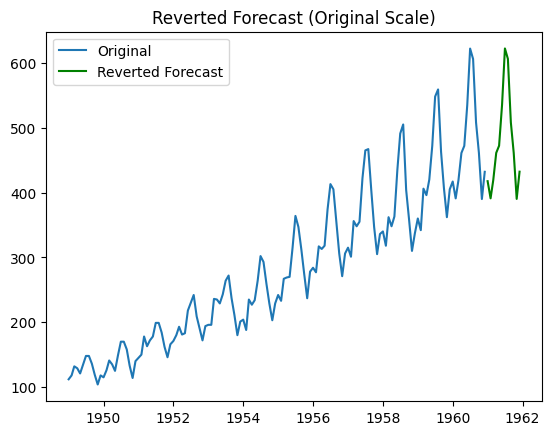

Reconstructed Forecasted Values:
1960-12-31    417.532200
1961-01-31    391.068612
1961-02-28    419.208877
1961-03-31    461.166438
1961-04-30    472.179279
1961-05-31    535.175393
1961-06-30    622.176569
1961-07-31    606.176213
1961-08-31    508.176321
1961-09-30    461.176288
1961-10-31    390.176298
1961-11-30    432.176295
Freq: ME, dtype: float64


In [5]:
# Get the last 12 original values for reversion
last_12_original = df[-12:]

# Create an empty list to store the reverted forecast
original_forecast = []

# Loop through the forecasted values and revert them to the original scale
for i in range(len(forecast)):
    # Use the seasonal lag to revert
    if i < 12:
        reverted_value = forecast[i] + last_12_original[i % 12]
    else:
        reverted_value = forecast[i] + original_forecast[i - 12]
    original_forecast.append(reverted_value)

# Convert the list to a pandas Series for consistency
original_forecast_series = pd.Series(original_forecast, index=forecast_index)

# Plot the reverted forecast alongside the original series
plt.figure()
plt.plot(df.index.to_timestamp(), df, label='Original')
plt.plot(original_forecast_series.index, original_forecast_series, label='Reverted Forecast', color='green')
plt.legend()
plt.title('Reverted Forecast (Original Scale)')
plt.show()


# Print the reconstructed forecasted values
print('Reconstructed Forecasted Values:')
print(original_forecast_series)

In [11]:
# Step 9: Optionally, consider SARIMA for better seasonal handling
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model (example with arbitrary seasonal order)
seasonal_model = SARIMAX(df, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
seasonal_fit = seasonal_model.fit()
print(seasonal_fit.summary())

# Plot SARIMA residuals and ACF of residuals
residuals_sarima = pd.DataFrame(seasonal_fit.resid)
residuals_sarima
# plt.figure()
# plt.plot(residuals_sarima)
# plt.title('SARIMA Residuals')
# plt.show()

# plot_acf(residuals_sarima)
# plt.title('ACF of SARIMA Residuals')
# plt.show()

# End of script

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -503.024
Date:                              Thu, 21 Nov 2024   AIC                           1020.048
Time:                                      11:48:38   BIC                           1040.174
Sample:                                  01-31-1949   HQIC                          1028.226
                                       - 12-31-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4441      0.388      1.145      0.252      -0.316       1.204
ar.L2          0.32

,0
1949-01,112.000000
1949-02,6.002760
1949-03,13.999702
1949-04,-2.998735
1949-05,-8.000144
...,...
1960-08,-18.343631
1960-09,-2.769377
1960-10,10.535143
1960-11,-21.366674
